In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image
from typing import *

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model

In [127]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

## Load dataset

In [3]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=8)
test_loader_single = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

train_set = Dataset(x_train, y_train)
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=False, num_workers=8)
train_loader_single = data.DataLoader(dataset=train_set, batch_size=1, shuffle=False, num_workers=1)

## White patches

In [4]:
def apply_path(
    img: torch.Tensor,
    x: int,
    y: int,
    size: int,
) -> torch.Tensor:
    cv2.circle(img, (x, y), size, [255], -1)

## Cost function 

Model output is `(x, y, z, theta)`, where

* x - up down (depth, distance), between 0 and 3 m
* y - left right
* z - height
* theta - angle (not very reliable), 0 when person is facing the drone, 180 (in radians) when the person looks in the opposite direction


In [139]:
def cost_f(
    prediction,
    ground_truth,
) -> float:
    ground_truth = ground_truth[0]
    res = ((prediction[0] - ground_truth[0]) ** 2).detach().numpy().squeeze()
    return res

## Greedy selection

In [6]:
def select_greedy(
    k: int,
    size: int,
    stride: int,
    img: torch.Tensor,
    ground_truth: torch.Tensor,
    cost_f,
    model,
    find_dots_that_fix_prediction: bool = False
) -> Tuple[float, List[Tuple[float, float]]]:
    n, m = img[0][0].shape
    optimal_patches = []
    optimal_cost = 0
    for _ in range(k):
        highest_cost_so_far = 0
        if find_dots_that_fix_prediction:
            highest_cost_so_far = 1e18
        best_position_so_far = None
        for i in range(0, n, stride):
            for j in range(0, m, stride):
                img_copy = img.clone()
                apply_path(
                    img=img_copy[0][0].numpy(),
                    x=i,
                    y=j,
                    size=size,
                )
                cost = cost_f(
                    prediction=model(img_copy),
                    ground_truth=ground_truth,
                )
                if find_dots_that_fix_prediction:
                    if cost <= highest_cost_so_far and (i, j) not in optimal_patches:
                        highest_cost_so_far = cost
                        best_position_so_far = (i, j)
                else:
                    if cost >= highest_cost_so_far and (i, j) not in optimal_patches:
                        highest_cost_so_far = cost
                        best_position_so_far = (i, j)
                        
        optimal_patches.append(best_position_so_far)
        if find_dots_that_fix_prediction:
            optimal_cost = min(optimal_cost, highest_cost_so_far)
        else:
            optimal_cost = max(optimal_cost, highest_cost_so_far)
    return optimal_cost, optimal_patches
                






Results for stride = 5
Best cost for a single point 1.6510527
Cost on raw image: 0.23846864700317383
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 55), (15, 60), (25, 55)]
Total cost for all points:  1.3048995
Prediction after patches: tensor([[1.5721]], grad_fn=<UnsqueezeBackward0>)


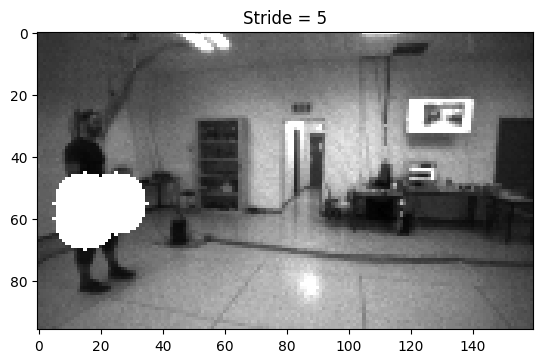





Results for stride = 10
Best cost for a single point 1.2669193
Cost on raw image: 0.23846864700317383
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(20, 80), (30, 80), (10, 60)]
Total cost for all points:  0.9966302
Prediction after patches: tensor([[1.7161]], grad_fn=<UnsqueezeBackward0>)


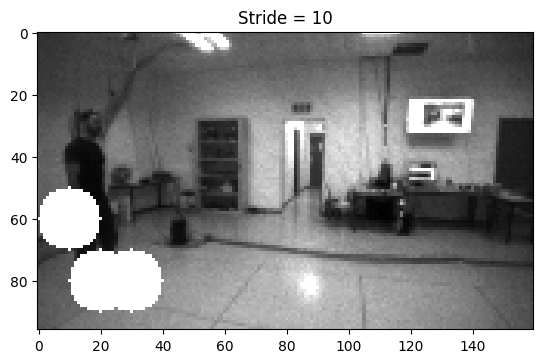





Results for stride = 15
Best cost for a single point 1.5004632
Cost on raw image: 0.23846864700317383
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 60), (30, 75), (45, 75)]
Total cost for all points:  2.4975195
Prediction after patches: tensor([[1.1340]], grad_fn=<UnsqueezeBackward0>)


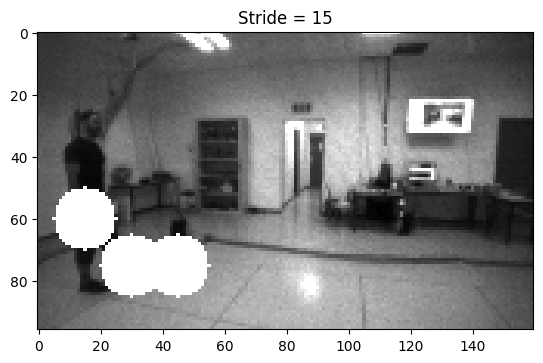

In [7]:
%%time
for stride in (5, 10, 15):
    img = next(iter(test_loader_single))[0]
    best_cost, optimal_greedy_points = select_greedy(
        k=3,
        img=img,
        size=10,
        stride=stride,
        ground_truth=next(iter(test_loader_single))[1],
        model=model,
        cost_f=cost_f
    )

    print("\n\n ======= \n\n")
    print(f"Results for stride = {stride}")
    print("Best cost for a single point", best_cost)
    print(f"Cost on raw image: {cost_f(model(img), next(iter(test_loader_single))[1])}")
    print(f"Prediction on raw: {model(img)[0]}")
    print(optimal_greedy_points)

    for x, y in optimal_greedy_points:
        apply_path(
            img=img[0][0].numpy(),
            x=x,
            y=y,
            size=10,
        )

    print(
        "Total cost for all points: ", 
        cost_f(model(img), next(iter(test_loader_single))[1])
    )
    print(f"Prediction after patches: {model(img)[0]}")
    plt.imshow(img[0][0].numpy(), cmap="gray")
    plt.title(f"Stride = {stride}")
    plt.show()

### Do the opposite - try to find dots that help the model to do a correct prediction





Results for stride = 5
Cost on raw image: 0.23846864700317383
Best cost for a single point 0
[(95, 55), (95, 30), (95, 35)]
Total cost for all points:  0.0001921323


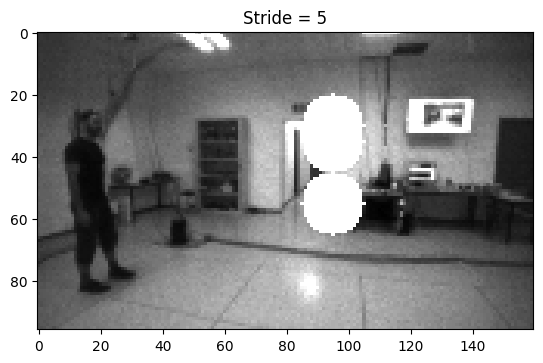





Results for stride = 10
Cost on raw image: 0.23846864700317383
Best cost for a single point 0
[(90, 60), (30, 30), (60, 50)]
Total cost for all points:  0.05049629


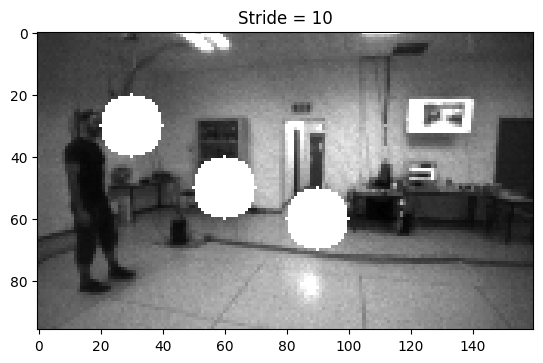





Results for stride = 15
Cost on raw image: 0.23846864700317383
Best cost for a single point 0
[(90, 60), (30, 30), (0, 45)]
Total cost for all points:  0.06360659


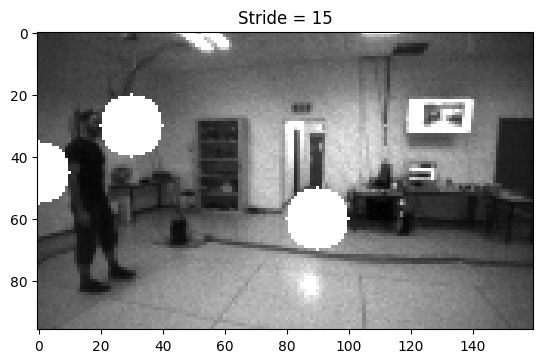

CPU times: user 10.7 s, sys: 6.51 s, total: 17.2 s
Wall time: 16.6 s


In [8]:
%%time
for stride in (5, 10, 15):
    img = next(iter(test_loader_single))[0]
    best_cost, optimal_greedy_points = select_greedy(
        k=3,
        img=img,
        size=10,
        stride=stride,
        ground_truth=next(iter(test_loader_single))[1],
        model=model,
        cost_f=cost_f,
        find_dots_that_fix_prediction=True,
    )

    print("\n\n ======= \n\n")
    print(f"Results for stride = {stride}")
    print(f"Cost on raw image: {cost_f(model(img), next(iter(test_loader_single))[1])}")
    print("Best cost for a single point", best_cost)
    print(optimal_greedy_points)

    for x, y in optimal_greedy_points:
        apply_path(
            img=img[0][0].numpy(),
            x=x,
            y=y,
            size=10,
        )

    print(
        "Total cost for all points: ", 
        cost_f(model(img), next(iter(test_loader_single))[1])
    )
    plt.imshow(img[0][0].numpy(), cmap="gray")
    plt.title(f"Stride = {stride}")
    plt.show()

## Simulated annealing

..


In [12]:
from scipy.optimize import basinhopping

In [132]:
def optimize_for_one_image(
    img: torch.Tensor,
    ground_truth: torch.Tensor,
    size: int,
    x: int,
    y: int
) -> float:
    x = int(x)
    y = int(y)
    img_copy = img.clone()
    apply_path(
        img=img_copy[0][0].numpy(),
        x=x,
        y=y,
        size=size,
    )
    #  we want to maximize the cost
    cost = -cost_f(
        prediction=model(img_copy),
        ground_truth=ground_truth,
    )
    return cost
    
def optimize_f(x):
    assert len(x) == 2
    # try with fixed image instead of whole dataset
    img_tensor, ground_truth = next(iter(train_loader_single))
    return optimize_for_one_image(
        img=img_tensor,
        ground_truth=ground_truth,
        size=10,
        x=x[0],
        y=x[1]
    )
    

In [77]:
class MyTakeStep:
   def __init__(self, stepsize=10):
       self.stepsize = stepsize
       self.rng = np.random.default_rng()
    
   def __call__(self, x):
       assert len(x) == 2
       x[0] += np.random.randint(-2 * self.stepsize, 2 * self.stepsize)
       x[0] = max(x[0], 0)
       x[0] = min(x[0], 160)
       x[1] += np.random.randint(-2 * self.stepsize, 2 * self.stepsize)
       x[1] = max(x[1], 0)
       x[1] = min(x[1], 160)
       return x

In [84]:
%%time

rng = np.random.default_rng()
minimizer_kwargs = {"method": "BFGS"}
x0 = [10, 10]
mytakestep = MyTakeStep(stepsize=20)

def print_fun(x, f, accepted):
    print(f"x={x}, f={f:.5f}, accepted: {accepted}")

ret = basinhopping(
    optimize_f, 
    x0, 
    minimizer_kwargs=minimizer_kwargs,
    niter=100, 
    callback=print_fun, 
    seed=rng,
    take_step=mytakestep,
)

print(ret)

x=[10. 10.], f=-0.00031, accepted: True
x=[41.  0.], f=-0.00036, accepted: True
x=[78. 14.], f=-0.00293, accepted: True
x=[38. 33.], f=-0.03629, accepted: True
x=[22.  4.], f=-0.00004, accepted: True
x=[47.  0.], f=-0.00219, accepted: True
x=[42.  0.], f=-0.00055, accepted: True
x=[7. 0.], f=-0.00036, accepted: True
x=[39. 11.], f=-0.00544, accepted: True
x=[ 6. 23.], f=-0.00092, accepted: True
x=[0. 0.], f=-0.00256, accepted: True
x=[ 0. 13.], f=-0.00622, accepted: True
x=[ 0. 19.], f=-0.00004, accepted: True
x=[ 0. 27.], f=-0.00389, accepted: True
x=[21. 40.], f=-0.00290, accepted: True
x=[25. 77.], f=-0.13920, accepted: True
x=[46. 46.], f=-0.00072, accepted: True
x=[25. 40.], f=-0.00013, accepted: True
x=[0. 8.], f=-0.01162, accepted: True
x=[0. 0.], f=-0.00256, accepted: True
x=[ 0. 11.], f=-0.01016, accepted: True
x=[ 0. 11.], f=-0.01016, accepted: True
x=[ 0. 26.], f=-0.00117, accepted: True
x=[ 1. 45.], f=-0.01043, accepted: True
x=[30. 39.], f=-0.04420, accepted: True
x=[64. 2

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11fece8b0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/selectors.py", line 416, in

x=[13. 63.], f=-0.01078, accepted: True
x=[13. 44.], f=-0.00024, accepted: True
x=[30. 77.], f=-0.02611, accepted: True
x=[ 41. 114.], f=-0.00124, accepted: True
x=[ 60. 152.], f=-0.00124, accepted: True
x=[ 95. 160.], f=-0.00124, accepted: True
x=[129. 153.], f=-0.00124, accepted: True
x=[100. 160.], f=-0.00124, accepted: True
x=[ 78. 160.], f=-0.00124, accepted: True
x=[ 70. 122.], f=-0.00124, accepted: True
x=[ 30. 117.], f=-0.00124, accepted: True
x=[ 14. 119.], f=-0.00124, accepted: True
x=[ 0. 84.], f=-0.04928, accepted: True
x=[  0. 122.], f=-0.00124, accepted: False
x=[  0. 106.], f=-0.00124, accepted: True
x=[  7. 114.], f=-0.00124, accepted: True
x=[40. 75.], f=-0.02423, accepted: True
x=[46. 81.], f=-0.05456, accepted: True
x=[71. 94.], f=-0.00755, accepted: True
x=[101.  62.], f=-0.14953, accepted: True
x=[125.  64.], f=-0.00972, accepted: False
x=[109. 105.], f=-0.00005, accepted: False
x=[119.  89.], f=-0.07418, accepted: True
x=[ 80. 120.], f=-0.00124, accepted: True
x=[

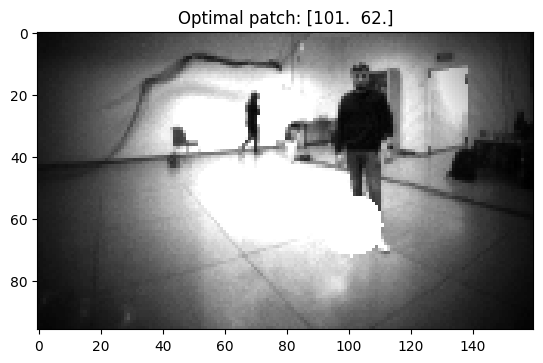

In [86]:
img, ground_truth = next(iter(train_loader_single))
apply_path(
    img[0][0].numpy(),
    x=int(ret.x[0]),
    y=int(ret.x[1]),
    size=10,
)
plt.imshow(img[0][0].numpy(), cmap="gray")
plt.title(f"Optimal patch: {ret.x}")
plt.show()

### Custom implementation

In [214]:
class SA:
    def __init__(
        self, 
        x0: Tuple[int, int],
        stride: int = 10,
        max_iters: int = 10000,
        alpha: float = 1.0,
    ):
        self._max_iters = max_iters
        self._stride = stride
        self._alpha = alpha
        self._dot_size = 10
        self._stepsize = stride
        self.solution = x0
        self.best_solution = x0
        self.cost = self._objective_function(x=x0[0], y=x0[1])
        self.best_cost = self.cost
        self.cost_history = []
        self.good_jumps = 0
        self.random_jumps = 0
        assert len(x0) == 2

    def _objective_function(self, x, y) -> float:
        img_tensor, ground_truth = next(iter(train_loader_single))
        return optimize_for_one_image(
            img=img_tensor,
            ground_truth=ground_truth,
            size=self._dot_size,
            x=x,
            y=y
        )

    def _random_neighbor(self) -> Tuple[int, int]:
        # img size is 160 x 96
        x, y = self.solution
        x += np.random.randint(-2 * self._stepsize, 2 * self._stepsize)
        x = max(x, 0)
        x = min(x, 160)
        
        y += np.random.randint(-2 * self._stepsize, 2 * self._stepsize)
        y = max(y, 0)
        y = min(y, 96)
        return (x, y)
        
    def print_summary(self) -> None:
        img, ground_truth = next(iter(train_loader_single))
        raw_cost = -cost_f(
            prediction=model(img),
            ground_truth=ground_truth,
        )
        img_copy = img.clone()
        apply_path(
            img_copy[0][0].numpy(),
            x=int(self.best_solution[0]),
            y=int(self.best_solution[1]),
            size=self._dot_size,
        )
        print(f"Steps: {self._max_iters}")
        print(f"Best solution: {self.best_solution}")
        print(f"Best cost: {self.best_cost}")
        print(f"Number of good jumps: {self.good_jumps}")
        print(f"Number of random jumps: {self.random_jumps}")
        print(f"Raw cost: {raw_cost}")
        print(f"Ground truth: {ground_truth}")
        raw_pred = model(img)
        raw_pred = list(map(lambda x: round(float(x.detach().numpy().squeeze()), 4), raw_pred))
        print(f"Prediction on raw: {raw_pred}")
        patch_pred = model(img_copy)
        patch_pred = list(map(lambda x: round(float(x.detach().numpy().squeeze()), 4), patch_pred))
        print(f"Prediction with patch: {patch_pred}")
        
        plt.figure(figsize=(15, 5))
        plt.plot(self.cost_history)
        plt.title('Cost history')
        plt.show()
       
        
        plt.imshow(img_copy[0][0].numpy(), cmap="gray")
        plt.title(f"Optimal patch = {self.best_solution}")
        plt.show()
        
    def run(self):
        for t in tqdm(range(self._max_iters), desc='Simulated Annealing', position=0):
            x, y = self._random_neighbor()
            new_cost = self._objective_function(x=x, y=y)
            
            # we minimize the cost function
            if new_cost < self.cost:
                self.cost = new_cost
                self.solution = (x, y)
                self.good_jumps += 1
                
            elif np.random.rand() < np.exp(-self._alpha * (new_cost - self.cost) * t / self._max_iters):
                self.cost = new_cost
                self.solution = (x, y)
                self.random_jumps += 1
            
            if self.cost < self.best_cost:
                self.best_cost = self.cost
                self.best_solution = self.solution
            self.cost_history.append(self.cost)
        
        self.print_summary()

In [217]:
optimizer = SA(
    # x0=(96 // 2, 160 // 2),
    x0=(110, 20),
    stride=10,
    max_iters=100
)

Simulated Annealing: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Steps: 100
Best solution: (108, 44)
Best cost: -0.6071854829788208
Number of good jumps: 49
Number of random jumps: 51
Raw cost: -0.0012437525438144803
Ground truth: tensor([[ 2.9725, -0.7274,  0.3108, -0.1638]])
Prediction on raw: [3.0078, -0.7261, 0.3504, -0.2849]
Prediction with patch: [2.1933, -0.5765, 0.2446, 0.8429]


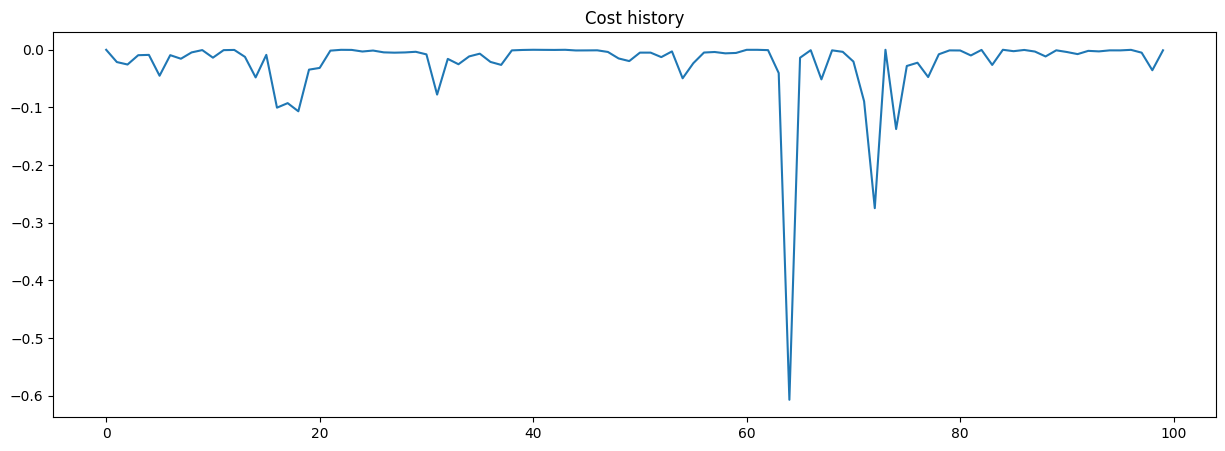

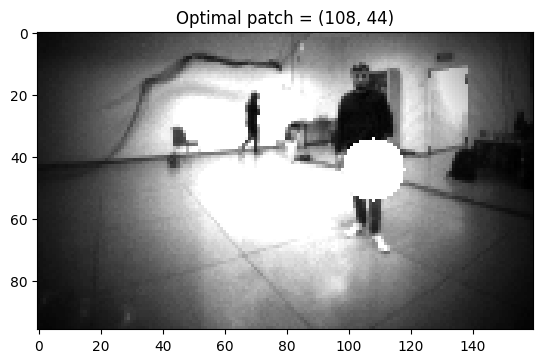

In [218]:
optimizer.run()

### TODO: jumping visualization